<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Time" data-toc-modified-id="Time-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time</a></span></li><li><span><a href="#Quality" data-toc-modified-id="Quality-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quality</a></span></li><li><span><a href="#precision,-recall,-query_time-vs-n_cells" data-toc-modified-id="precision,-recall,-query_time-vs-n_cells-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><code>precision, recall, query_time</code> vs <code>n_cells</code></a></span></li><li><span><a href="#precision,-recall,-query_time-vs-n_subvectors" data-toc-modified-id="precision,-recall,-query_time-vs-n_subvectors-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><code>precision, recall, query_time</code> vs <code>n_subvectors</code></a></span></li></ul></div>

In [1]:
## Benchmark pqlite

In [28]:
import pqlite
pqlite.__path__
import time

import jina
from jina.math.distance import cdist

import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [266]:
import random
import numpy as np
from pqlite import PQLite

#N = 100_000 # number of data points
Nt = 125_000 
Nq = 1
D = 128 # dimentionality / number of features
top_k = 100
n_cells = 64
n_subvectors = 8

# 2,000 128-dim vectors for training
np.random.seed(123)
Xtr, Xte =train_test_split(make_blobs(n_samples = Nt, n_features = D)[0].astype(np.float32), test_size=20)
#Xt = np.random.random((Nt, D)).astype(np.float32)  

# the column schema: (name:str, dtype:type, create_index: bool)
pq = PQLite(d_vector=D, n_cells=n_cells, n_subvectors=n_subvectors, columns=[('x', float, True)])
pq.fit(Xtr)
pq.add(Xtr, ids=list(range(len(Xtr))))

2021-11-12 11:59:12.656 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 124980 data...
2021-11-12 11:59:18.060 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 124980 data...
2021-11-12 12:00:28.780 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-12 12:00:32.764 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 124980 for 64 cells
2021-11-12 12:00:32.784 | DEBUG    | pqlite.storage.cell:insert:90 - => 124980 new items added


In [66]:
Nq = 1
query = Xte[[10]]  # a 128-dim query vector

# without filtering
pq_dists, ids = pq.search(query, k=5)

### Time

In [67]:
%timeit  pq.search(query,  k=top_k)

19.1 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
%timeit res = cdist(query, Xt, metric='euclidean')

13.7 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Quality

Manually observing slices of a high dimensional space it seems that the
retrieved items from pqlite are nearby the query and the best values from the exact and exhaustive distance computations.

In [156]:
true_distances = cdist(query, Xtr, metric='euclidean').flatten()
true_ids = np.argsort(true_distances)[0:top_k]
true_dists = true_distances[np.argsort(true_distances)]
print(true_dists)
print(true_ids)

[11.999227 12.10384  12.237079 ... 90.645004 90.817116 90.84127 ]
[ 32752  79685  50135  99260  96141  28624  60723  76192 102057  85071
  61047   3499   7520  21476   5235 109536  64612  39622  40892  99351
  92996  70076  14439 117112  77629  99463   7006  51265  82407  24776
  19415  40235  49875  82409   3681   6167  18629  63413  74319 121117
 122270 113201  23981  63556 120683 111096   6154 116482  38163  28614
  62019  37335  68626 114809   2243  67188  70199  84605 101848 118104
  95048  69695  22912 102048 112612  28146  95893  45989 111069  76656
 116714  86030 119408  79243  77748  29083  87230 108065  86645    319
  69152  18775  75920  24449  94513  54966 103333  94068 102020 114397
  22963  25285  49044  17352  50497  50640  10443 120999  33482  40365]


In [157]:
pq_dists, pq_ids = pq.search(query,  k=top_k)
pq_ids = np.array([int(x) for x in pq_ids[0]])

In [158]:
import matplotlib.pyplot as plt

def paint_slice(Xtr, query, feat1, feat2):
    plt.scatter(Xtr[:,feat1], Xtr[:,feat2], color='blue', alpha=0.2)

    for pq_id in pq_ids:
        plt.scatter(Xtr[pq_id, feat1], Xtr[pq_id, feat2], color='black')

    for true_id in true_ids:
        plt.scatter(Xtr[true_id, feat1], Xtr[true_id, feat2], color='orange')

    plt.scatter(query[:, feat1], query[:, feat2], color='red')
    

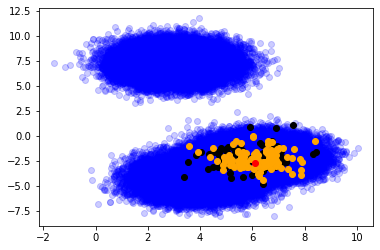

In [159]:
feat1, feat2 = 0, 1
paint_slice(Xtr, query, feat1, feat2)

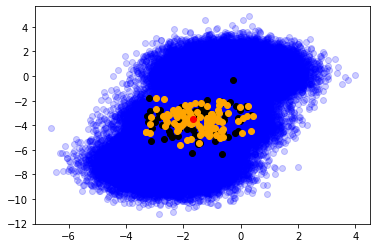

In [160]:
feat1, feat2 = 8, 100
paint_slice(Xtr, query, feat1, feat2)

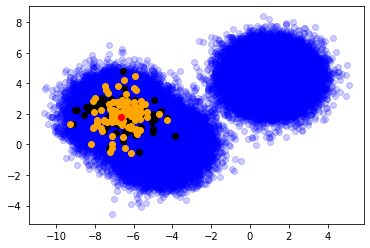

In [161]:
feat1, feat2 = 3,4
paint_slice(Xtr, query, feat1, feat2)

In [210]:
def _precision(predicted, relevant, eval_at):
    """
    fraction of retrieved documents that are relevant to the query
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))

    return n_predicted_and_relevant / len(predicted)

def _recall(predicted, relevant, eval_at):
    """
    fraction of the relevant documents that are successfully retrieved
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))
    return n_predicted_and_relevant/ len(relevant)


In [211]:
print(_precision(true_ids, pq_ids, top_k))
print(_recall(true_ids, pq_ids, top_k))

0.08
0.08


###  `precision, recall, query_time` vs `n_cells`

In [267]:
import time

def evaluate_query(query, Xtr, pq, top_k):
    pq_dists, ids = pq.search(query, k=top_k)

    true_distances = cdist(query, Xtr, metric='euclidean').flatten()
    true_ids = np.argsort(true_distances)[0:top_k]
    true_dists = true_distances[np.argsort(true_distances)]
    recall = _recall(true_ids, pq_ids, top_k)
    precision = _recall(true_ids, pq_ids, top_k)
    return precision, recall

In [270]:
np.random.seed(123)
Xtr, Xte =train_test_split(make_blobs(n_samples = Nt, n_features = D)[0].astype(np.float32), 
                           test_size=0.20)
#Xt = np.random.random((Nt, D)).astype(np.float32)  

In [271]:
len(Xtr), len(Xte)

(100000, 25000)

In [279]:
precision_per_query = []
recall_per_query = []
results = []

#N = 100_000 # number of data points
Nt = 125_000 
Nq = 1
D = 128 # dimentionality / number of features
n_subvectors = 8
top_k = 100
n_queries = 1000

for n_cells in [8,16,32,64,128]:
    pq = PQLite(d_vector=D, 
                n_cells=n_cells,
                n_subvectors=n_subvectors, 
                columns=[('x', float, True)])

    t0 = time.time()
    pq.fit(Xtr)    
    pq.add(Xtr, ids=list(range(len(Xtr))))
    index_time = abs(t0 -time.time())
    
    np.random.seed(123)
    n_query_ids = np.random.choice(len(Xte),n_queries, replace=False)
    
    t0 = time.time()
    
    for query_id in n_query_ids:
        query = Xte[[query_id], :]
        precision, recall = evaluate_query(query, Xtr, pq, top_k)
        precision_per_query.append(precision)
        recall_per_query.append(recall)

    query_time = abs(t0 -time.time())
    
    results_dict = { 'average_precision': np.mean(precision_per_query),
                     'average_recall': np.mean(recall_per_query),
                     'index_time':index_time,
                     'query_time':query_time,
                     'indexer_hyperparams':{'n_cells': n_cells,
                                            'n_subvectors': n_subvectors}
                    }
    
    results.append(results_dict)

2021-11-12 12:05:26.203 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 100000 data...
2021-11-12 12:05:29.172 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 100000 data...
2021-11-12 12:06:28.789 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-12 12:06:32.858 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 100000 for 6 cells
2021-11-12 12:06:32.864 | DEBUG    | pqlite.storage.cell:insert:90 - => 100000 new items added
2021-11-12 12:08:25.218 | INFO     | pqlite.index:fit:90 - => start training VQ codec with 100000 data...
2021-11-12 12:08:28.889 | INFO     | pqlite.index:fit:93 - => start training PQ codec with 100000 data...
2021-11-12 12:09:24.788 | INFO     | pqlite.index:fit:96 - => pqlite is successfully trained!
2021-11-12 12:09:27.624 | DEBUG    | pqlite.storage.cell:_expand:148 - => total storage capacity is expanded by 100000 for 16 cells
2021-11-12 12:09:27.630 | DEBU

In [291]:
import pandas as pd
results_df = pd.DataFrame(results)

The results are terrible, the only expected thing is that the query time decreses with the number of cells increasing

In [294]:
results_df

,average_precision,average_recall,index_time,query_time,indexer_hyperparams
0,0.00069,0.00069,66.666325,112.344714,"{'n_cells': 8, 'n_subvectors': 8}"
1,0.00069,0.00069,62.416446,81.455379,"{'n_cells': 16, 'n_subvectors': 8}"
2,0.00069,0.00069,64.707142,56.168816,"{'n_cells': 32, 'n_subvectors': 8}"
3,0.00069,0.00069,60.594037,42.682325,"{'n_cells': 64, 'n_subvectors': 8}"
4,0.00069,0.00069,63.217939,36.738292,"{'n_cells': 128, 'n_subvectors': 8}"



###  `precision, recall, query_time` vs `n_subvectors`